# Importing libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

tfk = tf.keras
tfkl = tf.keras.layers
#print(tf.__version__)

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/CHALLENGE 1/
%ls

Mounted at /gdrive
/gdrive/MyDrive/CHALLENGE 1
Augmentation_CNN_model/      DRTNet.ipynb       SubmissionModel/
balanced/                    FineTuning.ipynb   Tbtest.ipynb
balanced.zip                 FineTuningModel/   training/
dataset.zip                  InceptionNetV3/
DRTNet-InceptionNetV3.ipynb  MobileNetV2Model/


# Importing images

In [ ]:
# !unzip dataset.zip

labels = ['Apple',
          'Blueberry',
          'Cherry',
          'Corn',
          'Grape',
          'Orange',
          'Peach',
          'Pepper',
          'Potato',
          'Raspberry',
          'Soybean',
          'Squash',
          'Strawberry',
          'Tomato']


In [ ]:
def custom_preprocess(image, probs = [0.4, 0.2, 0.2, 0.3]):
    """ probs are a list of length 3
      prob[0] constrols the noise added to the black background
      prob[1] constrols swapping of color channels
      prob[2] constrols HSV hue of the image
      prob[3] constrols blurring of image
      """
      # see https://stackoverflow.com/questions/57265893/change-colors-with-imagedatagenerator
    # Generate random values
    A,B,C,D = np.random.rand(4)
    
    # Define propabilites for each of the three augmentations
    if len(probs) != 4:
        raise ValueError("Lenght of threshold should be 3")
    else:
        thresholds = probs
        
    
    # Adds noise in the black background
    if A <= thresholds[0]:
        BACKGROUND_VALUE = 0 # Here I assume that 0 is the background colour
        size = image[image==BACKGROUND_VALUE].shape[0] 
        values = np.random.uniform(low=image.min(), high=image.max(), size=(size,))
        image[image==0] = values
    
    # Swap color channels
    if B <= thresholds[1]:
        dims = np.arange(3)
        np.random.shuffle(dims)
        image = image[...,[dims[0],dims[1],dims[2]]]
    
    # Change the hue of the image
    if C <= thresholds[2]:
        image = np.uint8(np.array(image))
        image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        image = image.astype(np.float32)
        
    # Blurs the image slightly
    if D <= thresholds[3]:
        image = cv2.blur(image,(5,5))
    return image

def get_loaders(batch_size,IMG_SHAPE=(224,224,3),validation_split = 0.1,
                training_dir = 'dataset/training/', seed=33):
  
  # See following for how train/val split is enforced when from same directory
  # https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
  labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']
  aug_train = ImageDataGenerator(validation_split=validation_split,
                                 rotation_range = 45,
                                 width_shift_range = 0.2,
                                 height_shift_range = 0.2,
                                 brightness_range = [0.3,1.3],
                                 shear_range = 10,
                                 zoom_range = [0.3,1.2],
                                 channel_shift_range = 40,
                                 horizontal_flip  = True,
                                 vertical_flip = True,
                                 preprocessing_function = custom_preprocess,
                                 rescale=1/255.
                                  )
  aug_val = ImageDataGenerator(validation_split=validation_split,
                                 rescale=1/255.
                                  )
  train_loader = aug_train.flow_from_directory(directory=training_dir,
                                                           target_size=IMG_SHAPE[:-1],
                                                           color_mode='rgb',
                                                           classes=labels, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size= batch_size,
                                                           shuffle=True,
                                                           seed=seed,
                                                           subset='training')
  val_loader = aug_val.flow_from_directory(directory=training_dir,
                                                           target_size=IMG_SHAPE[:-1],
                                                           color_mode = 'rgb',
                                                           classes=labels, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size= batch_size,
                                                           shuffle=True,
                                                           seed=seed,
                                                           subset='validation')
  return train_loader,val_loader


In [ ]:
batch_size = 32
image_shape=(299,299,3)
validation_split = 0.15
training_dir = 'balanced/'

train_loader,val_loader = get_loaders(batch_size,image_shape,validation_split,training_dir,seed)

Found 14364 images belonging to 14 classes.
Found 2520 images belonging to 14 classes.


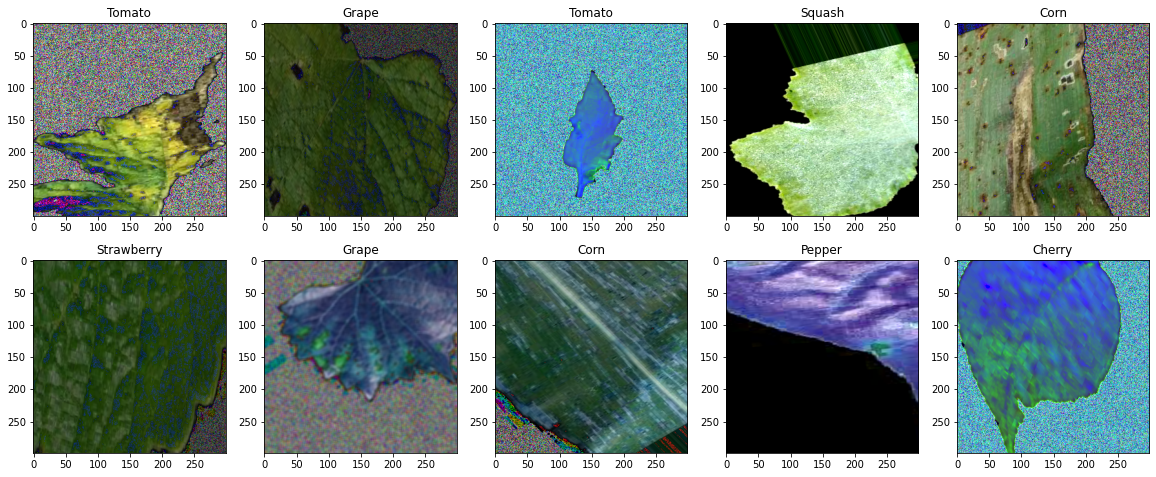

Max value of images : 1.0


In [ ]:
X,y = next(train_loader)

MAX_N = 5
N = X.shape[0]//2 if X.shape[0]//2 < MAX_N else MAX_N
f,ax = plt.subplots(2,N, figsize=(20,8))
ax = ax.flatten()
for i in range(2*N):
  if np.max(X) > 1.0:
    ax[i].imshow(np.uint8(X[i]))
  else:
    ax[i].imshow(X[i])
  ax[i].set_title(labels[np.argmax(y[i])])
plt.show()

print("Max value of images :", np.max(X))

# Transfer Learning

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
supernet = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    classifier_activation="softmax",
)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=image_shape)
x = tfkl.Rescaling(255., offset=0)(inputs) # Go from [0,1] to [0,255]
x = preprocess_input(x)
#x = tfkl.Resizing(224, 224, interpolation="bicubic")(inputs)
x = supernet(x)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.2, seed=seed)(x)       
x = tfkl.Dense(256, activation='relu', kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Activation('relu')(x)
x = tfkl.Dropout(0.2, seed=seed)(x)
outputs = tfkl.Dense(14, activation='softmax', kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
#tl_model.summary()

In [ ]:
# Train the model
tl_model_hist = tl_model.fit(
    x = train_loader,
    epochs = 15,
    validation_data = val_loader,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)],
    verbose = 1
).history

# Plot on matlab

Epoch 1/15
449/449 [==============================] - 3188s 7s/step - loss: 1.3114 - accuracy: 0.5807 - val_loss: 0.5915 - val_accuracy: 0.8202
Epoch 2/15
449/449 [==============================] - 461s 1s/step - loss: 0.9566 - accuracy: 0.6871 - val_loss: 0.5149 - val_accuracy: 0.8508
Epoch 3/15
449/449 [==============================] - 461s 1s/step - loss: 0.9119 - accuracy: 0.7054 - val_loss: 0.4629 - val_accuracy: 0.8643
Epoch 4/15
449/449 [==============================] - 460s 1s/step - loss: 0.8720 - accuracy: 0.7203 - val_loss: 0.4640 - val_accuracy: 0.8607
Epoch 5/15
449/449 [==============================] - 449s 999ms/step - loss: 0.8618 - accuracy: 0.7210 - val_loss: 0.3830 - val_accuracy: 0.8877
Epoch 6/15
449/449 [==============================] - 451s 1s/step - loss: 0.8315 - accuracy: 0.7298 - val_loss: 0.3977 - val_accuracy: 0.8798
Epoch 7/15
449/449 [==============================] - 454s 1s/step - loss: 0.8439 - accuracy: 0.7266 - val_loss: 0.3301 - val_accuracy: 0.

In [ ]:
tl_model.save('InceptionNetV3')

INFO:tensorflow:Assets written to: InceptionNetV3/assets


# Fine Tuning

In [ ]:
ft_model = tfk.models.load_model('InceptionNetV3')

In [ ]:
ft_model.summary()
len(ft_model.get_layer('inception_v3').layers)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

311

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
N = 249

ft_model.get_layer('inception_v3').trainable = True
for i, layer in enumerate((ft_model.get_layer('inception_v3')).layers):
    if i<=N:
      layer.trainable = False
    print(i, layer.name, layer.trainable)


0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0001), metrics='accuracy')

In [ ]:
# Train the fine-tune model
ft_epochs = 10
ft_history = ft_model.fit(
    x = train_loader,
    epochs = ft_epochs,
    validation_data = val_loader,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
    verbose = 1
).history

Epoch 1/10
449/449 [==============================] - 3163s 7s/step - loss: 0.6517 - accuracy: 0.7894 - val_loss: 0.1744 - val_accuracy: 0.9464
Epoch 2/10
449/449 [==============================] - 466s 1s/step - loss: 0.4616 - accuracy: 0.8505 - val_loss: 0.1119 - val_accuracy: 0.9690
Epoch 3/10
449/449 [==============================] - 463s 1s/step - loss: 0.3890 - accuracy: 0.8799 - val_loss: 0.0778 - val_accuracy: 0.9770
Epoch 4/10
449/449 [==============================] - 456s 1s/step - loss: 0.3409 - accuracy: 0.8910 - val_loss: 0.0966 - val_accuracy: 0.9762
Epoch 5/10
449/449 [==============================] - 454s 1s/step - loss: 0.3238 - accuracy: 0.8948 - val_loss: 0.0834 - val_accuracy: 0.9722
Epoch 6/10
449/449 [==============================] - 449s 999ms/step - loss: 0.2900 - accuracy: 0.9056 - val_loss: 0.0585 - val_accuracy: 0.9829
Epoch 7/10
449/449 [==============================] - 437s 972ms/step - loss: 0.2800 - accuracy: 0.9088 - val_loss: 0.0782 - val_accuracy:

In [ ]:
ft_model.save('InceptionNetV3_FT')

INFO:tensorflow:Assets written to: InceptionNetV3_FT/assets


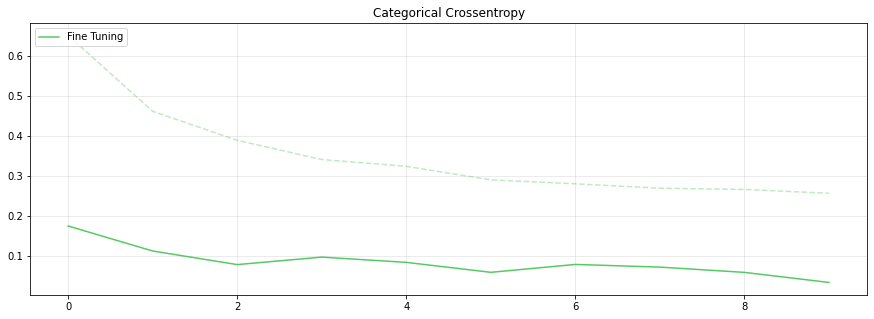

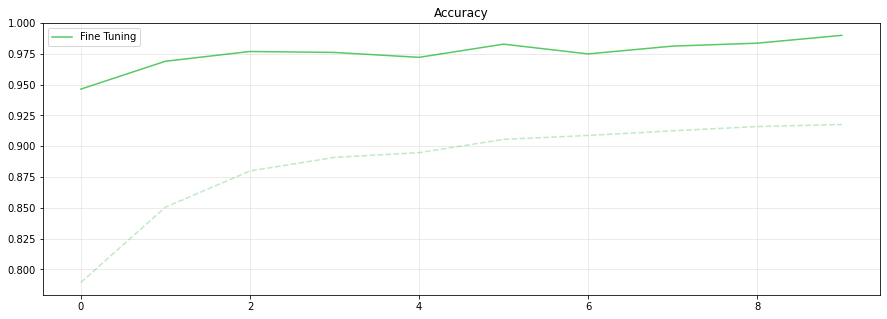

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()